In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
import timeseries_data
from ssm_em import StateSpaceEM
from scipy.stats import zscore

In [44]:
def run_experiment(data_df, whiten: bool=False, train_ratio: float=.5, model_params: dict={'Dz': 2, 'Du': 2}, init_with_pca: bool=False):
    if whiten:
        X = zscore(data_df.to_numpy())
    else:
        X = data_df.to_numpy()
    
    train_length = int(X.shape[0] * train_ratio)
    X_train = X[:train_length]
    X_test = X[train_length:]
    Dx = X_train.shape[1]
    Dz, Du = model_params['Dz'], model_params['Du']
    ##### Run linear model #####
    print('Fitting linear model')
    sm_lin = state_models.LinearStateModel(Dz)
    om_lin = observation_models.LinearObservationModel(Dx, Dz)
    if init_with_pca:
        om_lin.pca_init(X_train)
    linear_model = StateSpaceEM(X_train, observation_model=om_lin, state_model=sm_lin)
    linear_model.run()
    ##### Run heteroscedastic model #####
    print('Fitting heteroscedastic model')
    sm_hs = state_models.LinearStateModel(Dz)
    om_hs = observation_models.HCCovObservationModel(Dx, Dz, Du)
    if init_with_pca:
        om_hs.pca_init(X_train)
    hs_model = StateSpaceEM(X_train, observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    return linear_model, hs_model, X_train, X_test
    
    
def eval_model(X, model):
    llk = model.compute_predictive_log_likelihood(X)
    predictions = model.predict(X, smoothed=True)
    return llk, predictions

def plot_prediction(X, model, figsize: tuple=None, var_names: list=None):
    data_density = model.compute_predictive_density(X)
    mu = data_density.mu
    std = data_density.Sigma.diagonal(axis1=-2, axis2=-1)
    upper = mu + 1.68 * std
    lower = mu - 1.68 * std
    num_steps, num_vars = X.shape
    if var_names is None:
        var_names = ['x_%d' %i for i in range(num_vars)]
    fig = pyplot.figure(figsize=figsize)
    for iplot in range(num_vars):
        ax = fig.add_subplot(num_vars, 1, iplot+1)
        ax.plot(X[:,iplot], 'C%d' %iplot)
        ax.fill_between(range(num_steps), upper[:,iplot], lower[:,iplot], color='k', alpha=.5, lw=0, zorder=9)
        ax.set_ylabel(var_names[iplot])
        if iplot < num_vars - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('timesteps')
    fig.tight_layout()
    return fig

def plot_performance(X, models: list, model_names: list=None, figsize: tuple=None):
    num_models = len(models)
    if model_names is None:
        model_names = ['model %d' %(i+1) for i in range(num_models)]
    
    fig = pyplot.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for imodel, model in enumerate(models):
        test_llk = eval_model(X, model)[0]
        ax.bar([imodel], [test_llk])
    ax.set_ylabel('log likelihood')
    ax.set_xticks(range(num_models))
    ax.set_xticklabels(model_names, rotation=45)
    return fig

# Synthetic dataset

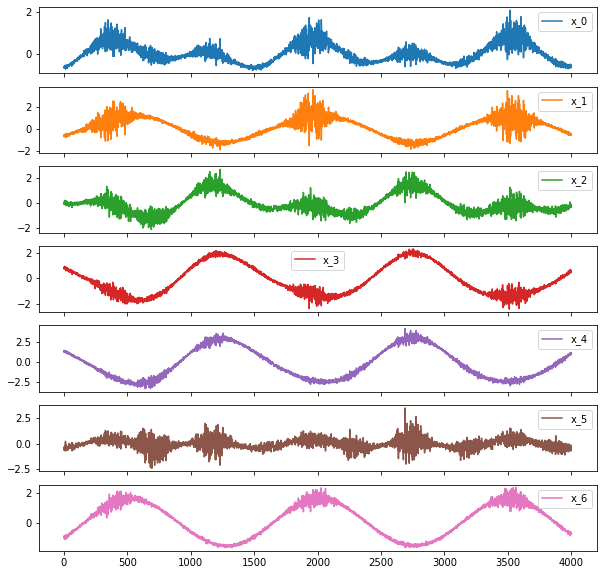

In [18]:
data_df = timeseries_data.load_synthetic_data()
data_df.plot(subplots=True, figsize=(10,10))
pyplot.show()

In [31]:
model_params = {'Dz': 2, 'Du': 6}
linear_model, hs_model, X_train, X_test = run_experiment(data_df, model_params=model_params, whiten=True, init_with_pca=True)

Fitting linear model
Iteration 2 - llk=3646.5
Iteration 4 - llk=7697.3
Iteration 6 - llk=10433.1
Iteration 8 - llk=12697.9
Iteration 10 - llk=14197.1
Iteration 12 - llk=14868.3
Iteration 14 - llk=15051.7
Iteration 16 - llk=15101.9
Iteration 18 - llk=15126.7
Iteration 20 - llk=15141.1
Iteration 22 - llk=15149.5
Iteration 24 - llk=15154.3
EM did converge.
Fitting heteroscedastic model
Iteration 2 - llk=-10735.1
Iteration 4 - llk=-3803.4
Iteration 6 - llk=3282.1
Iteration 8 - llk=8276.7
Iteration 10 - llk=14556.9
Iteration 12 - llk=15768.7
Iteration 14 - llk=16336.7
Iteration 16 - llk=16602.6
Iteration 18 - llk=16742.2
Iteration 20 - llk=16818.3
Iteration 22 - llk=16863.0
Iteration 24 - llk=16892.5
Iteration 26 - llk=16915.4
Iteration 28 - llk=16928.7
Iteration 30 - llk=16940.1
Iteration 32 - llk=16949.7
Iteration 34 - llk=16957.5
Iteration 36 - llk=16963.6
Iteration 38 - llk=16968.4
Iteration 40 - llk=16972.6
Iteration 42 - llk=16976.0
EM did converge.


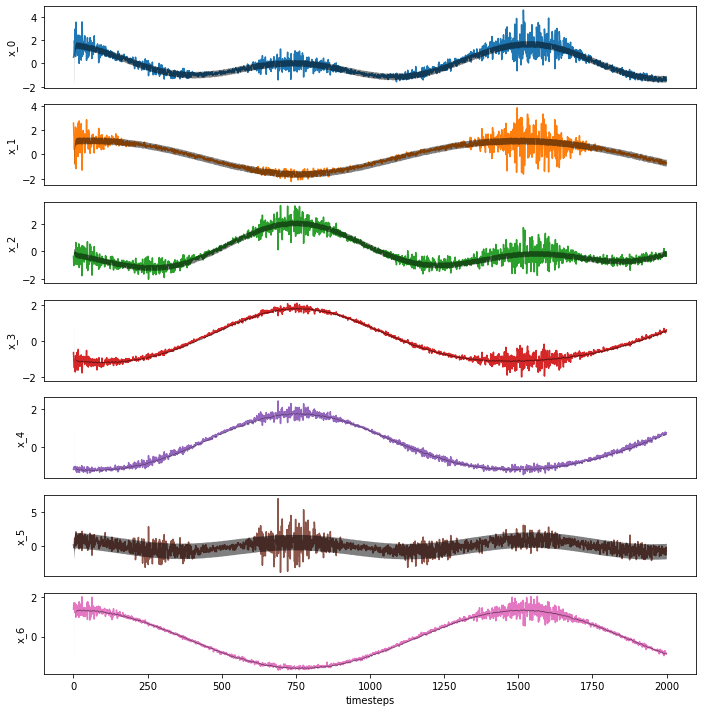

In [32]:
fig = plot_prediction(X_test, linear_model, figsize=(10,10))

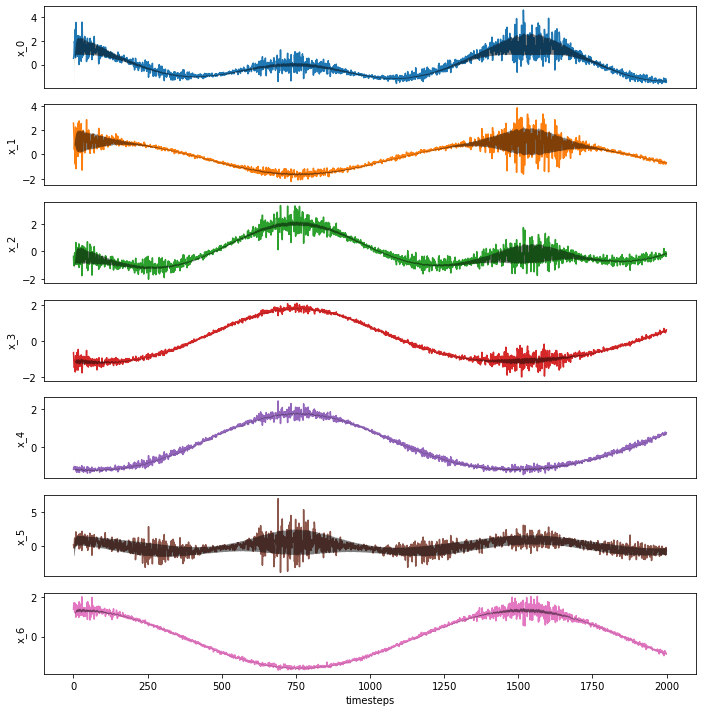

In [33]:
fig = plot_prediction(X_test, hs_model, figsize=(10,10))

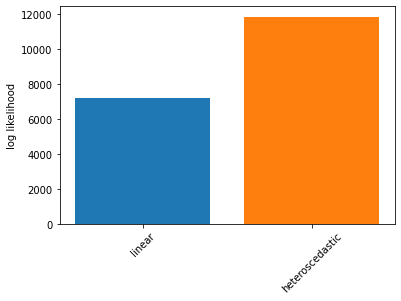

In [45]:
fig = plot_performance(X_test, [linear_model, hs_model], model_names=['linear', 'heteroscedastic'])